## Valores perdidos en series temporales

Existen varias variables meteorológicas en el set de datos `weather_train/test` que contienen valores perdidos. En este notebook probaremos la librería `imputeTS` de `R` para lidiar con estos casos.

### Pre-procesado de datos

In [93]:
rm(list = ls())

In [82]:
# Librerias
packages <- c("data.table","ggplot2","tidyverse","tidyr","dplyr"
             ,"tibble","forecast","tsfknn","anytime","varhandle","lubridate","nortest"
             ,"normtest","scales","xts","tsfknn","TSrepr","imputeTS")

In [83]:
# Función que carga las librerias que se indiquen, y las instala en caso de no estarlo

loadLibraries <- function(pakages) {
  usePackage <- function(p){
    if ( !is.element(p, installed.packages()[, 1]) ) {
      install.packages(p, dep = TRUE)}
    require(p, character.only = TRUE)}
  
  for (p in packages){ usePackage(p) }
  
}

In [84]:
# Carga de librerías
loadLibraries(packages)

In [85]:
# Importamos los datos
weather <- as.data.frame(read.csv("../data/interim/weather.csv", header = TRUE, sep = ","))
weather_by_site <- weather %>% group_by(weather$site_id)

In [6]:
head(weather)
tail(weather)

X,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,2016-01-01 00:00:00,25.0,6,20.0,NA,1019.5,0,0.0
1,0,2016-01-01 01:00:00,24.4,NA,21.1,-1,1020.0,70,1.5
2,0,2016-01-01 02:00:00,22.8,2,21.1,0,1020.0,0,0.0
3,0,2016-01-01 03:00:00,21.1,2,20.6,0,1020.0,0,0.0
4,0,2016-01-01 04:00:00,20.0,2,20.0,-1,1020.0,250,2.6
5,0,2016-01-01 05:00:00,19.4,NA,19.4,0,NA,0,0.0


,X,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139768,139767,15,2016-12-31 18:00:00,2.8,NA,-7.8,NA,1007.5,180,8.2
139769,139768,15,2016-12-31 19:00:00,3.0,NA,-8.0,NA,NA,180,5.7
139770,139769,15,2016-12-31 20:00:00,2.8,2,-8.9,NA,1007.5,180,7.7
139771,139770,15,2016-12-31 21:00:00,2.8,NA,-7.2,NA,1007.5,180,5.1
139772,139771,15,2016-12-31 22:00:00,2.2,NA,-6.7,NA,1008.0,170,4.6
139773,139772,15,2016-12-31 23:00:00,1.7,NA,-5.6,-1,1008.5,180,8.8


In [87]:
sites <- unique(weather$site_id)
print(sites)

 [1]  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15


In [88]:
# Convertimos a tipo fecha la columna timestamp
weather$timestamp <- unfactor(weather$timestamp)
weather$timestamp <- as.POSIXct(weather$timestamp, format = "%Y-%m-%d %H:%M", tz="GMT")

In [89]:
# Generamos un lista de series temporales de la variable `air_temperature`, una por cada `site_id`
airTempList = list()
for (site in sites){
    airTempList[[site+1]] <- xts((filter(weather,site_id==site))$air_temperature, order.by = filter(weather,site_id==site)$timestamp)
}


In [10]:
# Gráficas
# ...

ERROR: Error in eval(expr, envir, enclos): '...' usado en un contexto incorrecto


In [11]:
# Estadísticas sobre los valores perdidos de cada serie
n = 0
for (serie in airTempList){
    print(paste("**** SITE_ID: ", n))
    statsNA(serie)
    cat(sep="\n")
    n = n+1
          
}


[1] "**** SITE_ID:  0"
[1] "Length of time series:"
[1] 8784
[1] "-------------------------"
[1] "Number of Missing Values:"
[1] 3
[1] "-------------------------"
[1] "Percentage of Missing Values:"
[1] "0.0342%"
[1] "-------------------------"
[1] "Stats for Bins"
[1] "  Bin 1 (2196 values from 1 to 2196) :      3 NAs (0.137%)"
[1] "  Bin 2 (2196 values from 2197 to 4392) :      0 NAs (0%)"
[1] "  Bin 3 (2196 values from 4393 to 6588) :      0 NAs (0%)"
[1] "  Bin 4 (2196 values from 6589 to 8784) :      0 NAs (0%)"
[1] "-------------------------"
[1] "Longest NA gap (series of consecutive NAs)"
[1] "3 in a row"
[1] "-------------------------"
[1] "Most frequent gap size (series of consecutive NA series)"
[1] "3 NA in a row (occuring 1 times)"
[1] "-------------------------"
[1] "Gap size accounting for most NAs"
[1] "3 NA in a row (occuring 1 times, making up for overall 3 NAs)"
[1] "-------------------------"
[1] "Overview NA series"
[1] "  3 NA in a row: 1 times"

[1] "**** SITE_ID

### Imputación de valores perdidos

Vamos a probar distintos métodos del paquete `imputeTS`. Para comprobar su precisión, elegimos algún `site_id` cuya serie de valores de `air_temperature` no contenga ningún valor perdido. Asignaremos valores perdidos de manera aleatoria que rellenaremos con dichos métodos, para posteriormente calcular el error con respecto al valor original.

In [90]:
# El site_id 4 no tiene valores perdidos. Usaremos esta serie temporal para nuestras pruebas.

airTemp_site12 <- airTempList[[13]]
airTemp_site12_month1 <- airTemp_site12["2016-01-01/2016-01-31"]
airTemp_site12_month1_day8 <- airTemp_site12_month1["2016-01-08 00:00:00/2016-01-08 23:59:59"]

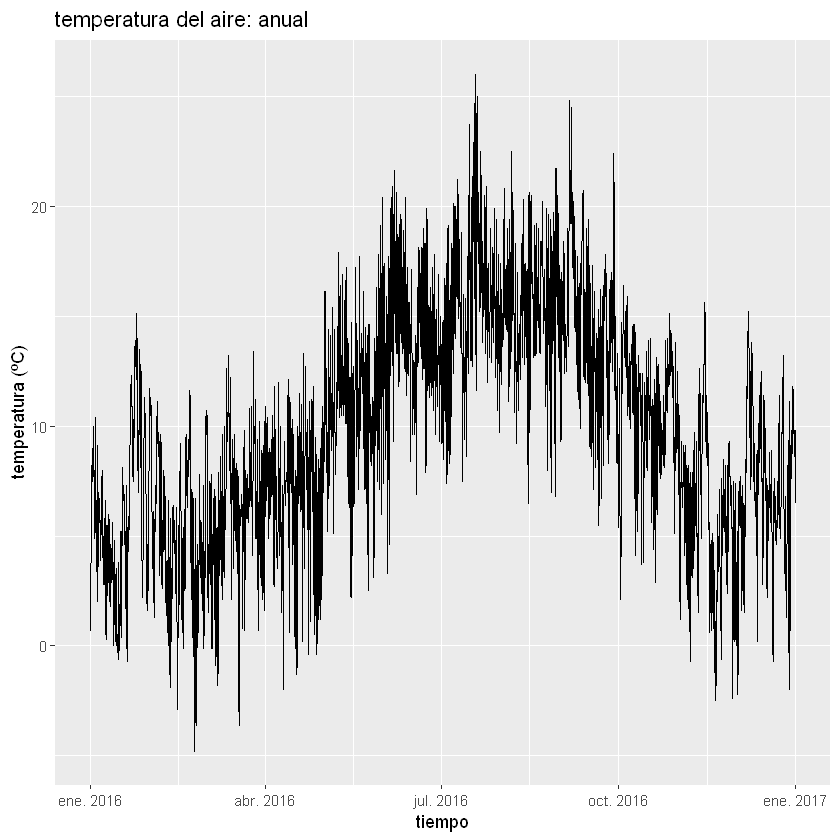

In [13]:
autoplot(airTemp_site12) +
  ggtitle("temperatura del aire: anual") +
  xlab("tiempo") +
  ylab("temperatura (ºC)")

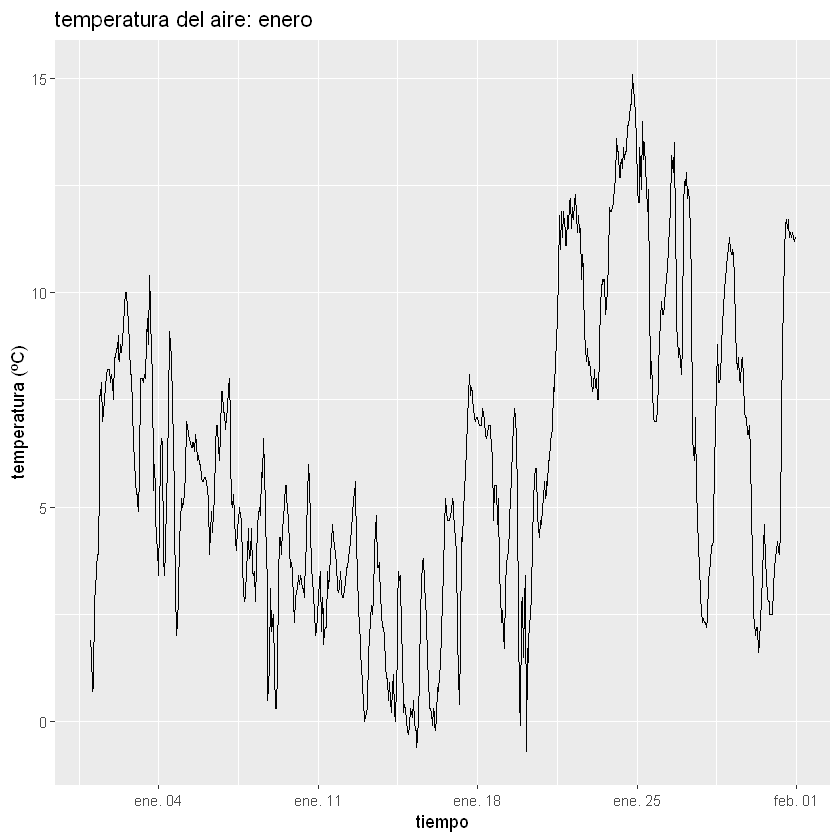

In [14]:
autoplot(airTemp_site12_month1) +
  ggtitle("temperatura del aire: enero") +
  xlab("tiempo") +
  ylab("temperatura (ºC)")

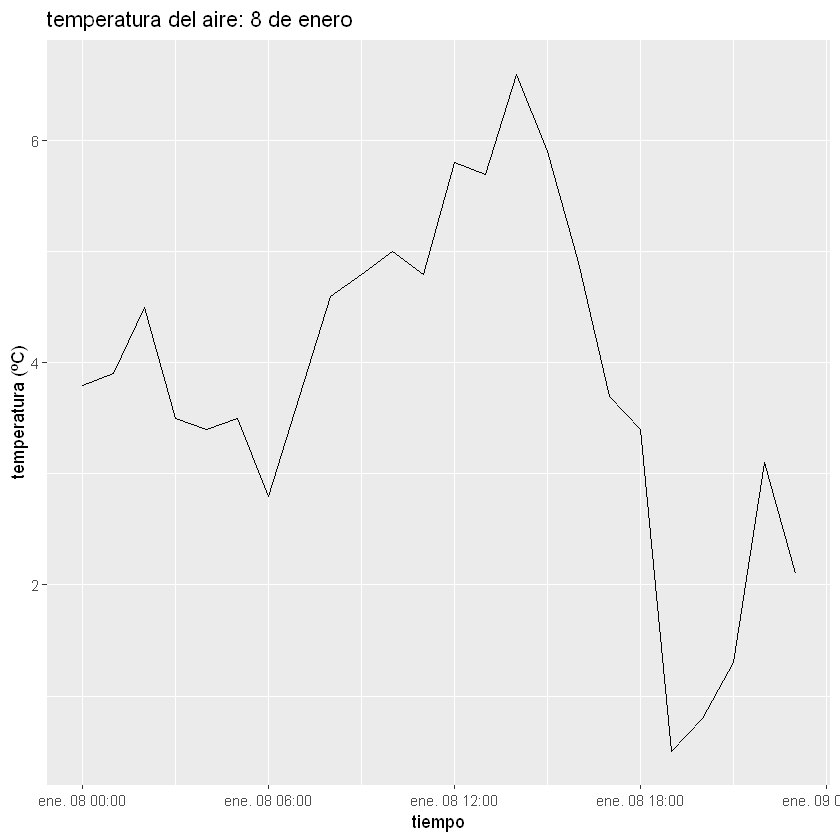

In [15]:
autoplot(airTemp_site12_month1_day8) +
  ggtitle("temperatura del aire: 8 de enero") +
  xlab("tiempo") +
  ylab("temperatura (ºC)")

In [16]:
statsNA(airTemp_site12)

[1] "Length of time series:"
[1] 8755
[1] "-------------------------"
[1] "Number of Missing Values:"
[1] 0
[1] "-------------------------"
[1] "Percentage of Missing Values:"
[1] "0%"
[1] "-------------------------"
[1] "No NAs in the time Series."


[1] "No NAs"

#### Asignación aleatoria de valores perdidos

In [91]:
# Copia de la serie donde asignaremos NAs
airTemp_site12_NA <- airTemp_site12

# Número de NAs
N <- 10

# Indices de la serie
inds <- as.vector(expand.grid(1:nrow(airTemp_site12_NA)))

# Muestra aleatoria
set.seed(666)
selected <- inds[sample(nrow(inds), N), ]

# Asignación de NA a los indices de la muestra aleatoria
airTemp_site12_NA[selected] <- NA

In [18]:
statsNA(airTemp_site12_NA)

[1] "Length of time series:"
[1] 8755
[1] "-------------------------"
[1] "Number of Missing Values:"
[1] 10
[1] "-------------------------"
[1] "Percentage of Missing Values:"
[1] "0.114%"
[1] "-------------------------"
[1] "Stats for Bins"
[1] "  Bin 1 (2189 values from 1 to 2189) :      5 NAs (0.228%)"
[1] "  Bin 2 (2189 values from 2190 to 4378) :      2 NAs (0.0914%)"
[1] "  Bin 3 (2189 values from 4379 to 6567) :      1 NAs (0.0457%)"
[1] "  Bin 4 (2188 values from 6568 to 8755) :      2 NAs (0.0914%)"
[1] "-------------------------"
[1] "Longest NA gap (series of consecutive NAs)"
[1] "1 in a row"
[1] "-------------------------"
[1] "Most frequent gap size (series of consecutive NA series)"
[1] "1 NA in a row (occuring 10 times)"
[1] "-------------------------"
[1] "Gap size accounting for most NAs"
[1] "1 NA in a row (occuring 10 times, making up for overall 10 NAs)"
[1] "-------------------------"
[1] "Overview NA series"
[1] "  1 NA in a row: 10 times"


#### Método 1: interpolación lineal

In [19]:
airTemp_site12[selected]

Warning message:
"timezone of object (GMT) is different than current timezone ()."

                    [,1]
2016-01-28 03:00:00  3.3
2016-02-06 08:00:00  5.6
2016-02-14 17:00:00  3.1
2016-03-07 23:00:00  3.2
2016-03-12 02:00:00  9.6
2016-04-10 18:00:00  8.5
2016-06-17 06:00:00 10.1
2016-09-19 10:00:00 12.5
2016-10-04 18:00:00 14.1
2016-10-31 19:00:00 11.0

In [20]:
airTemp_site12_NA_interpolated <- na_interpolation(airTemp_site12_NA, option = "linear")

In [21]:
statsNA(airTemp_site12_NA_interpolated)

[1] "Length of time series:"
[1] 8755
[1] "-------------------------"
[1] "Number of Missing Values:"
[1] 0
[1] "-------------------------"
[1] "Percentage of Missing Values:"
[1] "0%"
[1] "-------------------------"
[1] "No NAs in the time Series."


[1] "No NAs"

In [22]:
airTemp_site12_NA_interpolated[selected]

Warning message:
"timezone of object (GMT) is different than current timezone ()."

                     [,1]
2016-01-28 03:00:00  2.95
2016-02-06 08:00:00  5.70
2016-02-14 17:00:00  2.75
2016-03-07 23:00:00  3.50
2016-03-12 02:00:00 10.10
2016-04-10 18:00:00  8.65
2016-06-17 06:00:00 10.05
2016-09-19 10:00:00 12.30
2016-10-04 18:00:00 14.00
2016-10-31 19:00:00 10.00

Calculemos el error relativo para los valores interpolados con respecto a la serie original:

In [23]:
err_lineal <- round((abs(airTemp_site12[selected] - airTemp_site12_NA_interpolated[selected])/airTemp_site12) * 100,2)
print(err_lineal)

Warning message:
"timezone of object (GMT) is different than current timezone ()."

                       e1
2016-01-28 03:00:00 10.61
2016-02-06 08:00:00  1.79
2016-02-14 17:00:00 11.29
2016-03-07 23:00:00  9.37
2016-03-12 02:00:00  5.21
2016-04-10 18:00:00  1.76
2016-06-17 06:00:00  0.50
2016-09-19 10:00:00  1.60
2016-10-04 18:00:00  0.71
2016-10-31 19:00:00  9.09


Calculo del error relativo medio:

In [24]:
ERM_lineal <- mean(err_lineal)
print(round(ERM_lineal, 2))

[1] 5.19


#### Método 2: Interpolación con splines

In [25]:
airTemp_site12_NA_splin <- na_interpolation(airTemp_site12_NA, option = "spline")

In [26]:
statsNA(airTemp_site12_NA_splin)

[1] "Length of time series:"
[1] 8755
[1] "-------------------------"
[1] "Number of Missing Values:"
[1] 0
[1] "-------------------------"
[1] "Percentage of Missing Values:"
[1] "0%"
[1] "-------------------------"
[1] "No NAs in the time Series."


[1] "No NAs"

In [27]:
err_spline <- round((abs(airTemp_site12[selected] - airTemp_site12_NA_splin[selected])/airTemp_site12) * 100, 2)

In [28]:
ERM_spline <- mean(err_spline)

In [29]:
print(round(ERM_spline, 2))

[1] 6.97


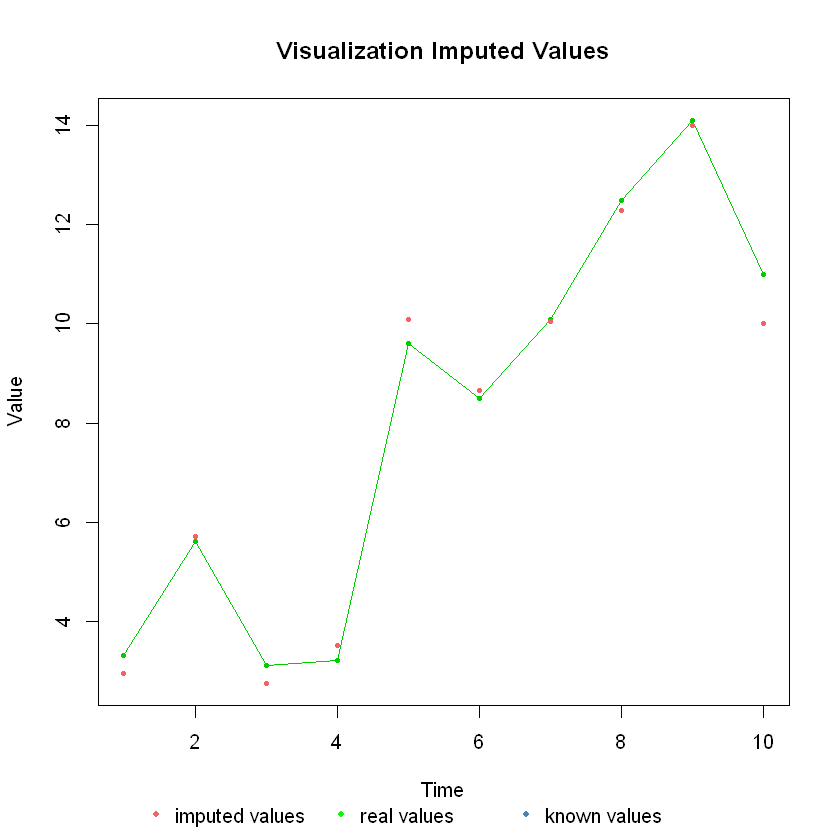

In [30]:
plotNA.imputations(airTemp_site12_NA[selected], x.withImputations = airTemp_site12_NA_interpolated[selected], x.withTruth = airTemp_site12[selected]) 

#### Método 3: Interpolación *Stineman*

In [31]:
airTemp_site12_NA_stineman <- na_interpolation(airTemp_site12_NA, option = "stine")

In [32]:
statsNA(airTemp_site12_NA_splin)

[1] "Length of time series:"
[1] 8755
[1] "-------------------------"
[1] "Number of Missing Values:"
[1] 0
[1] "-------------------------"
[1] "Percentage of Missing Values:"
[1] "0%"
[1] "-------------------------"
[1] "No NAs in the time Series."


[1] "No NAs"

In [33]:
err_stine <- round((abs(airTemp_site12[selected] - airTemp_site12_NA_stineman[selected])/airTemp_site12) * 100, 2)

In [34]:
ERM_stine <- mean(err_stine)
print(round(ERM_stine, 2))

[1] 5.21


In [35]:
err_spline

Warning message:
"timezone of object (GMT) is different than current timezone ()."

                       e1
2016-01-28 03:00:00  9.58
2016-02-06 08:00:00  4.03
2016-02-14 17:00:00 19.79
2016-03-07 23:00:00 11.54
2016-03-12 02:00:00  5.01
2016-04-10 18:00:00  2.47
2016-06-17 06:00:00  3.82
2016-09-19 10:00:00  0.11
2016-10-04 18:00:00  2.18
2016-10-31 19:00:00 11.13

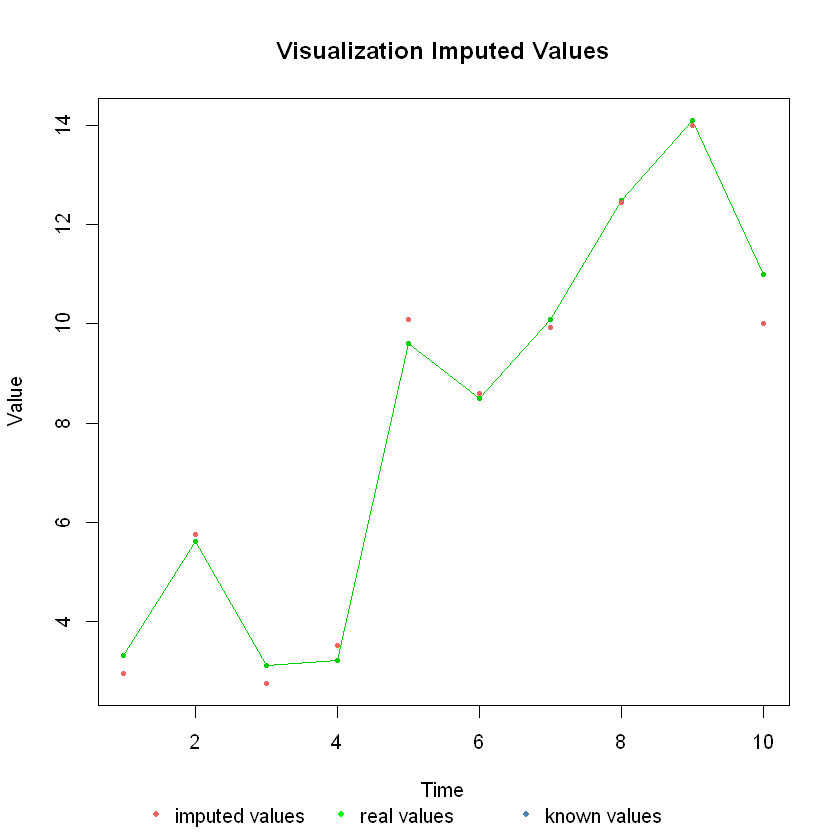

In [36]:
plotNA.imputations(airTemp_site12_NA[selected], x.withImputations = airTemp_site12_NA_stineman[selected], x.withTruth = airTemp_site12[selected]) 

De los tres métodos de interpolación empleados el que da una precisión mayor es el **Método de interpolación de Stineman**

#### Método 4: Kalman Smoothing

In [37]:
airTemp_site12_NA_kalStrct <- na_kalman(airTemp_site12_NA, model = "StructTS", smooth = TRUE, type = "trend")

In [38]:
statsNA(airTemp_site12_NA_kalStrct)

[1] "Length of time series:"
[1] 8755
[1] "-------------------------"
[1] "Number of Missing Values:"
[1] 0
[1] "-------------------------"
[1] "Percentage of Missing Values:"
[1] "0%"
[1] "-------------------------"
[1] "No NAs in the time Series."


[1] "No NAs"

In [39]:
err_kalStrct <- round((abs(airTemp_site12[selected] - airTemp_site12_NA_kalStrct[selected])/airTemp_site12) * 100, 2)

In [40]:
err_kalStrct

Warning message:
"timezone of object (GMT) is different than current timezone ()."

                       e1
2016-01-28 03:00:00 11.31
2016-02-06 08:00:00  1.60
2016-02-14 17:00:00 11.67
2016-03-07 23:00:00  8.69
2016-03-12 02:00:00  5.12
2016-04-10 18:00:00  2.02
2016-06-17 06:00:00  1.16
2016-09-19 10:00:00  1.24
2016-10-04 18:00:00  0.71
2016-10-31 19:00:00  9.39

In [41]:
ERM_kalStrct <- mean(err_kalStrct)
print(round(ERM_kalStrct, 2))

[1] 5.29


In [42]:
airTemp_site12_NA_kalArima <- na_kalman(airTemp_site12_NA, model = "auto.arima", smooth = TRUE)

In [43]:
err_kalArima <- round((abs(airTemp_site12[selected] - airTemp_site12_NA_kalArima[selected])/airTemp_site12) * 100, 2)

In [44]:
err_kalArima

Warning message:
"timezone of object (GMT) is different than current timezone ()."

                       e1
2016-01-28 03:00:00 11.09
2016-02-06 08:00:00  1.49
2016-02-14 17:00:00 11.72
2016-03-07 23:00:00  9.29
2016-03-12 02:00:00  5.37
2016-04-10 18:00:00  2.00
2016-06-17 06:00:00  1.45
2016-09-19 10:00:00  0.91
2016-10-04 18:00:00  0.60
2016-10-31 19:00:00 10.11

In [45]:
ERM_kalArima <- mean(err_kalArima)
print(round(ERM_kalArima, 2))

[1] 5.4


#### Método 5: Medias móviles

In [46]:
airTemp_site12_NA_mas <- na_ma(airTemp_site12_NA, k = 4, weighting = "simple")

In [47]:
err_mas <- round((abs(airTemp_site12[selected] - airTemp_site12_NA_mas[selected])/airTemp_site12) * 100, 2)

In [48]:
err_mas

Warning message:
"timezone of object (GMT) is different than current timezone ()."

                      e1
2016-01-28 03:00:00 6.82
2016-02-06 08:00:00 4.24
2016-02-14 17:00:00 0.00
2016-03-07 23:00:00 9.77
2016-03-12 02:00:00 4.82
2016-04-10 18:00:00 0.88
2016-06-17 06:00:00 8.79
2016-09-19 10:00:00 7.40
2016-10-04 18:00:00 0.44
2016-10-31 19:00:00 1.82

In [49]:
ERM_mas <- mean(err_mas)
print(round(ERM_mas, 2))

[1] 4.5


In [50]:
airTemp_site12_NA_mal <- na_ma(airTemp_site12_NA, k = 3, weighting = "linear")

In [51]:
err_mal <- round((abs(airTemp_site12[selected] - airTemp_site12_NA_mal[selected])/airTemp_site12) * 100, 2)

In [52]:
err_mal

Warning message:
"timezone of object (GMT) is different than current timezone ()."

                      e1
2016-01-28 03:00:00 8.86
2016-02-06 08:00:00 1.99
2016-02-14 17:00:00 0.50
2016-03-07 23:00:00 8.77
2016-03-12 02:00:00 4.85
2016-04-10 18:00:00 2.62
2016-06-17 06:00:00 4.91
2016-09-19 10:00:00 5.17
2016-10-04 18:00:00 0.05
2016-10-31 19:00:00 5.70

In [53]:
ERM_mal <- mean(err_mal)
print(round(ERM_mal, 2))

[1] 4.34


In [54]:
airTemp_site12_NA_mae <- na_ma(airTemp_site12_NA, k = 3, weighting = "exponential")

In [55]:
err_mae <- round((abs(airTemp_site12[selected] - airTemp_site12_NA_mae[selected])/airTemp_site12) * 100, 2)

In [56]:
ERM_mae <- mean(err_mae)
print(round(ERM_mae, 2))

[1] 4.49


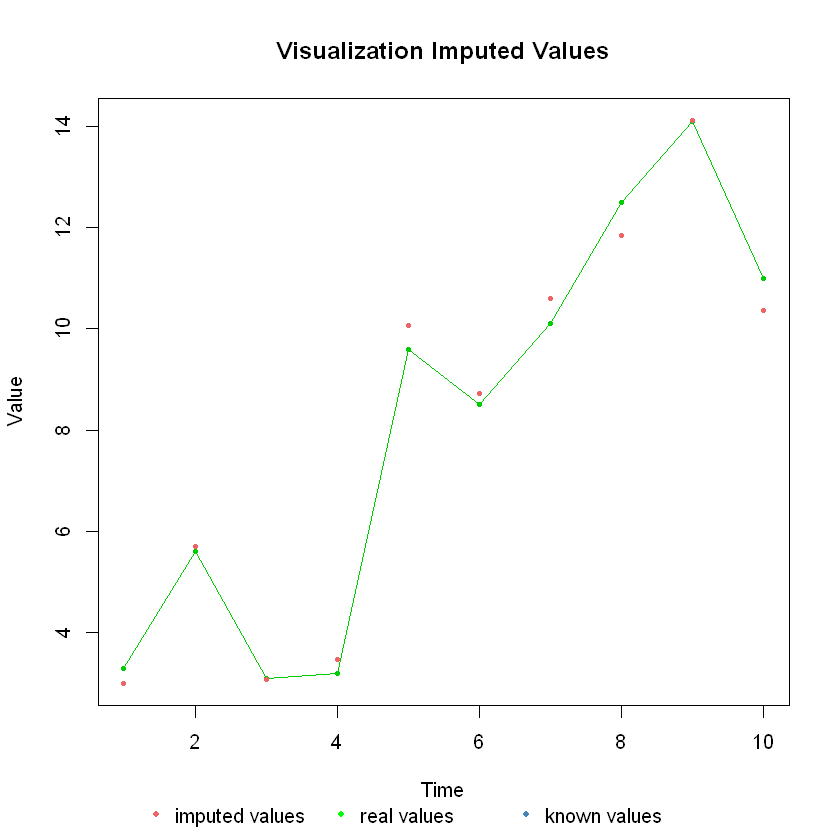

In [57]:
plotNA.imputations(airTemp_site12_NA[selected], x.withImputations = airTemp_site12_NA_mal[selected], x.withTruth = airTemp_site12[selected]) 

#### Método 6: Last Observation Carried Forward- LOCF y Next Observation Carried Backward- NOCB

In [59]:
airTemp_site12_NA_locf <- na_locf(airTemp_site12_NA, option = "locf", na_remaining = "rev")

In [60]:
err_locf <- round((abs(airTemp_site12[selected] - airTemp_site12_NA_locf[selected])/airTemp_site12) * 100, 2)

In [61]:
err_locf

Warning message:
"timezone of object (GMT) is different than current timezone ()."

                       e1
2016-01-28 03:00:00 27.27
2016-02-06 08:00:00  5.36
2016-02-14 17:00:00 32.26
2016-03-07 23:00:00 12.50
2016-03-12 02:00:00  1.04
2016-04-10 18:00:00  4.71
2016-06-17 06:00:00  4.95
2016-09-19 10:00:00  8.80
2016-10-04 18:00:00  3.55
2016-10-31 19:00:00  0.00

In [67]:
airTemp_site12_NA_nocb <- na_locf(airTemp_site12_NA, option = "nocb", na_remaining = "rev")

In [68]:
err_nocb <- round((abs(airTemp_site12[selected] - airTemp_site12_NA_locf[selected])/airTemp_site12) * 100, 2)

In [69]:
err_nocb

Warning message:
"timezone of object (GMT) is different than current timezone ()."

                       e1
2016-01-28 03:00:00 27.27
2016-02-06 08:00:00  5.36
2016-02-14 17:00:00 32.26
2016-03-07 23:00:00 12.50
2016-03-12 02:00:00  1.04
2016-04-10 18:00:00  4.71
2016-06-17 06:00:00  4.95
2016-09-19 10:00:00  8.80
2016-10-04 18:00:00  3.55
2016-10-31 19:00:00  0.00

#### Método 7: descomposición estacional

In [73]:
airTemp_site12_NA_dintl <- na_seasplit(airTemp_site12_NA, algorithm = "interpolation", option="linear", find_frequency = FALSE)

In [74]:
err_dintl <- round((abs(airTemp_site12[selected] - airTemp_site12_NA_dintl[selected])/airTemp_site12) * 100, 2)

In [75]:
err_dintl

Warning message:
"timezone of object (GMT) is different than current timezone ()."

                       e1
2016-01-28 03:00:00  6.05
2016-02-06 08:00:00  8.92
2016-02-14 17:00:00 54.81
2016-03-07 23:00:00  6.25
2016-03-12 02:00:00  9.37
2016-04-10 18:00:00  1.17
2016-06-17 06:00:00  3.96
2016-09-19 10:00:00  5.60
2016-10-04 18:00:00  4.96
2016-10-31 19:00:00 18.18

In [76]:
airTemp_site12_NA_dintsp<- na_seasplit(airTemp_site12_NA, algorithm = "interpolation", option="spline", find_frequency = FALSE)

In [78]:
err_dintsp <- round((abs(airTemp_site12[selected] - airTemp_site12_NA_dintsp[selected])/airTemp_site12) * 100, 2)

In [79]:
err_dintsp

Warning message:
"timezone of object (GMT) is different than current timezone ()."

                       e1
2016-01-28 03:00:00  6.06
2016-02-06 08:00:00  8.93
2016-02-14 17:00:00 54.84
2016-03-07 23:00:00  6.25
2016-03-12 02:00:00  9.37
2016-04-10 18:00:00  1.18
2016-06-17 06:00:00  3.96
2016-09-19 10:00:00  5.60
2016-10-04 18:00:00  4.96
2016-10-31 19:00:00 18.18

In [92]:
airTemp_site12_NA_dintst<- na_seasplit(airTemp_site12_NA, algorithm = "interpolation", option="stine", find_frequency = FALSE)

ERROR: Error: no se puede ubicar un vector de tamaño  120.1 Mb
